<a href="https://colab.research.google.com/github/Afgankhan/CycleGAN-for-Medical-Image-Style-Transfer-to-Natural-Images/blob/main/Cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/fastai/fastai.git

Cloning into 'fastai'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 32655 (delta 0), reused 1 (delta 0), pack-reused 32651
Receiving objects: 100% (32655/32655), 439.89 MiB | 14.71 MiB/s, done.
Resolving deltas: 100% (23838/23838), done.
Checking out files: 100% (818/818), done.


# 1. Load Data

In [ ]:
cd /content/fastai/courses/dl2

/content/fastai/courses/dl2


In [ ]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2020-06-05 18:29:13--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  20.8MB/s    in 6.3s    

2020-06-05 18:29:20 (17.7 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [ ]:
!unzip -q -n horse2zebra.zip

In [ ]:
from cgan.options.train_options import TrainOptions
from cgan.data.data_loader import CreateDataLoader

In [ ]:
opt = TrainOptions().parse(['--dataroot', 'horse2zebra', '--nThreads', '8', '--no_dropout',
                           '--niter', '100', '--niter_decay', '100', '--name', 'nodrop', '--gpu_ids', '0'])

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: horse2zebra
dataset_mode: unaligned
display_freq: 100
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 256
epoch_count: 1
fineSize: 256
gpu_ids: [0]
init_type: normal
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
lambda_identity: 0.5
loadSize: 286
lr: 0.0002
lr_decay_iters: 50
lr_policy: lambda
max_dataset_size: inf
model: cycle_gan
nThreads: 8
n_layers_D: 3
name: nodrop
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_dropout: True
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
resize_or_crop: resize_and_crop
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
update_html_freq: 1000
which_direction: AtoB
which_epoch: latest
which_model_netD: basic
which_model_netG: resnet_9blocks
-------------- End ----------------


In [ ]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
dataset_size

CustomDatasetDataLoader
dataset [UnalignedDataset] was created


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


1334

# 2. Model

In [ ]:
import torch
from collections import OrderedDict
from torch.autograd import Variable
import itertools
import os

In [ ]:
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [ ]:
from __future__ import print_function
import torch
import numpy as np
from PIL import Image
import random

## 2.1 Base Model

In [ ]:
class BaseModel():
    def name(self): return 'BaseModel'

    def initialize(self, opt):
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.Tensor = torch.cuda.FloatTensor if self.gpu_ids else torch.Tensor
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)

    def set_input(self, input): self.input = input
    def forward(self): pass
    def test(self): pass
    def get_image_paths(self): pass
    def optimize_parameters(self): pass
    def get_current_visuals(self): return self.input
    def get_current_errors(self): return {}
    def save(self, label): pass

    # helper saving function that can be used by subclasses
    def save_network(self, network, network_label, epoch_label, gpu_ids):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if len(gpu_ids) and torch.cuda.is_available(): network.cuda(gpu_ids[0])

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

    # update learning rate (called once every epoch)
    def update_learning_rate(self):
        for scheduler in self.schedulers: scheduler.step()
        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

## 2.2 Network

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def define_G(input_nc, output_nc, ngf, which_model_netG, norm='batch', use_dropout=False, init_type='normal', gpu_ids=[]):
    netG = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert(torch.cuda.is_available())

    if which_model_netG == 'resnet_9blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9, gpu_ids=gpu_ids)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % which_model_netG)
    if len(gpu_ids) > 0:
        netG.cuda(gpu_ids[0])
    init_weights(netG, init_type=init_type)
    return netG


def define_D(input_nc, ndf, which_model_netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', gpu_ids=[]):
    netD = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert(torch.cuda.is_available())
    if which_model_netD == 'basic':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_ids=gpu_ids)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' %
                                  which_model_netD)
    if use_gpu:
        netD.cuda(gpu_ids[0])
    init_weights(netD, init_type=init_type)
    return netD


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [ ]:
##############################################################################
# Classes
##############################################################################


# Defines the GAN loss which uses either LSGAN or the regular GAN.
# When LSGAN is used, it is basically same as MSELoss,
# but it abstracts away the need to create the target label tensor
# that has the same size as the input
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_ids=[], padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

## 2.3 Utils

In [ ]:
# Converts a Tensor into a Numpy array
# |imtype|: the desired type of the converted numpy array
def tensor2im(image_tensor, imtype=np.uint8):
    image_numpy = image_tensor[0].cpu().float().numpy()
    if image_numpy.shape[0] == 1:
        image_numpy = np.tile(image_numpy, (3, 1, 1))
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)


def diagnose_network(net, name='network'):
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)


def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(image_path)


def print_numpy(x, val=True, shp=False):
    x = x.astype(np.float64)
    if shp:
        print('shape,', x.shape)
    if val:
        x = x.flatten()
        print('mean = %3.3f, min = %3.3f, max = %3.3f, median = %3.3f, std=%3.3f' % (
            np.mean(x), np.min(x), np.max(x), np.median(x), np.std(x)))


def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return Variable(images)
        return_images = []
        for image in images:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

## 2.4 Cycle GAN

In [ ]:
class CycleGANModel(BaseModel):
    def name(self):
        return 'CycleGANModel'

    def initialize(self, opt):
        BaseModel.initialize(self, opt)
        # load/define networks
        # The naming conversion is different from those used in the paper
        # Code (paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)

        self.netG_A = define_G(opt.input_nc, opt.output_nc,
                                        opt.ngf, opt.which_model_netG, opt.norm, not opt.no_dropout, opt.init_type, self.gpu_ids)
        self.netG_B = define_G(opt.output_nc, opt.input_nc,
                                        opt.ngf, opt.which_model_netG, opt.norm, not opt.no_dropout, opt.init_type, self.gpu_ids)

        if self.isTrain:
            use_sigmoid = opt.no_lsgan
            self.netD_A = define_D(opt.output_nc, opt.ndf,
                                            opt.which_model_netD,
                                            opt.n_layers_D, opt.norm, use_sigmoid, opt.init_type, self.gpu_ids)
            self.netD_B = define_D(opt.input_nc, opt.ndf,
                                            opt.which_model_netD,
                                            opt.n_layers_D, opt.norm, use_sigmoid, opt.init_type, self.gpu_ids)
        if not self.isTrain or opt.continue_train:
            which_epoch = opt.which_epoch
            self.load_network(self.netG_A, 'G_A', which_epoch)
            self.load_network(self.netG_B, 'G_B', which_epoch)
            if self.isTrain:
                self.load_network(self.netD_A, 'D_A', which_epoch)
                self.load_network(self.netD_B, 'D_B', which_epoch)

        if self.isTrain:
            self.fake_A_pool = ImagePool(opt.pool_size)
            self.fake_B_pool = ImagePool(opt.pool_size)
            # define loss functions
            self.criterionGAN = GANLoss(use_lsgan=not opt.no_lsgan, tensor=self.Tensor)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # initialize optimizers
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
                                                lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers = []
            self.schedulers = []
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D_A)
            self.optimizers.append(self.optimizer_D_B)
            for optimizer in self.optimizers:
                self.schedulers.append(get_scheduler(optimizer, opt))

        print('---------- Networks initialized -------------')
        print_network(self.netG_A)
        print_network(self.netG_B)
        if self.isTrain:
            print_network(self.netD_A)
            print_network(self.netD_B)
        print('-----------------------------------------------')

    def set_input(self, input):
        AtoB = self.opt.which_direction == 'AtoB'
        input_A = input['A' if AtoB else 'B']
        input_B = input['B' if AtoB else 'A']
        if len(self.gpu_ids) > 0:
            input_A = input_A.cuda(self.gpu_ids[0], async=True)
            input_B = input_B.cuda(self.gpu_ids[0], async=True)
        self.input_A = input_A
        self.input_B = input_B
        self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        self.real_A = Variable(self.input_A)
        self.real_B = Variable(self.input_B)

    def test(self):
        real_A = Variable(self.input_A, volatile=True)
        fake_B = self.netG_A(real_A)
        self.rec_A = self.netG_B(fake_B).data
        self.fake_B = fake_B.data

        real_B = Variable(self.input_B, volatile=True)
        fake_A = self.netG_B(real_B)
        self.rec_B = self.netG_A(fake_A).data
        self.fake_A = fake_A.data

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def backward_D_basic(self, netD, real, fake):
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        # backward
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)
        self.loss_D_A = loss_D_A.item()

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)
        self.loss_D_B = loss_D_B.item()

    def backward_G(self):
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed.
            idt_A = self.netG_A(self.real_B)
            loss_idt_A = self.criterionIdt(idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed.
            idt_B = self.netG_B(self.real_A)
            loss_idt_B = self.criterionIdt(idt_B, self.real_A) * lambda_A * lambda_idt

            self.idt_A = idt_A.data
            self.idt_B = idt_B.data
            self.loss_idt_A = loss_idt_A.item()
            self.loss_idt_B = loss_idt_B.item()
        else:
            loss_idt_A = 0
            loss_idt_B = 0
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        fake_B = self.netG_A(self.real_A)
        pred_fake = self.netD_A(fake_B)
        loss_G_A = self.criterionGAN(pred_fake, True)

        # GAN loss D_B(G_B(B))
        fake_A = self.netG_B(self.real_B)
        pred_fake = self.netD_B(fake_A)
        loss_G_B = self.criterionGAN(pred_fake, True)

        # Forward cycle loss
        rec_A = self.netG_B(fake_B)
        loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * lambda_A

        # Backward cycle loss
        rec_B = self.netG_A(fake_A)
        loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * lambda_B
        # combined loss
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        loss_G.backward()

        self.fake_B = fake_B.data
        self.fake_A = fake_A.data
        self.rec_A = rec_A.data
        self.rec_B = rec_B.data

        self.loss_G_A = loss_G_A.item()
        self.loss_G_B = loss_G_B.item()
        self.loss_cycle_A = loss_cycle_A.item()
        self.loss_cycle_B = loss_cycle_B.item()

    def optimize_parameters(self):
        # forward
        self.forward()
        # G_A and G_B
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        # D_A
        self.optimizer_D_A.zero_grad()
        self.backward_D_A()
        self.optimizer_D_A.step()
        # D_B
        self.optimizer_D_B.zero_grad()
        self.backward_D_B()
        self.optimizer_D_B.step()

    def get_current_errors(self):
        ret_errors = OrderedDict([('D_A', self.loss_D_A), ('G_A', self.loss_G_A), ('Cyc_A', self.loss_cycle_A),
                                  ('D_B', self.loss_D_B), ('G_B', self.loss_G_B), ('Cyc_B', self.loss_cycle_B)])
        if self.opt.lambda_identity > 0.0:
            ret_errors['idt_A'] = self.loss_idt_A
            ret_errors['idt_B'] = self.loss_idt_B
        return ret_errors

    def get_current_visuals(self):
        real_A = tensor2im(self.input_A)
        fake_B = tensor2im(self.fake_B)
        rec_A = tensor2im(self.rec_A)
        real_B = tensor2im(self.input_B)
        fake_A = tensor2im(self.fake_A)
        rec_B = tensor2im(self.rec_B)
        ret_visuals = OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A),
                                   ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B)])
        if self.opt.isTrain and self.opt.lambda_identity > 0.0:
            ret_visuals['idt_A'] = tensor2im(self.idt_A)
            ret_visuals['idt_B'] = tensor2im(self.idt_B)
        return ret_visuals

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label, self.gpu_ids)
        self.save_network(self.netD_A, 'D_A', label, self.gpu_ids)
        self.save_network(self.netG_B, 'G_B', label, self.gpu_ids)
        self.save_network(self.netD_B, 'D_B', label, self.gpu_ids)

    def load(self, label):
        self.load_network(self.netG_A, 'G_A', label)
        self.load_network(self.netD_A, 'D_A', label)
        self.load_network(self.netG_B, 'G_B', label)
        self.load_network(self.netD_B, 'D_B', label)

In [ ]:
def create_model(opt):
    model = None
    print(opt.model)
    if opt.model == 'cycle_gan':
        assert(opt.dataset_mode == 'unaligned')
        model = CycleGANModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)
    model.initialize(opt)
    print("model [%s] was created" % (model.name()))
    return model

# 3. Training

In [ ]:
import time
from tqdm import tqdm

In [ ]:
model = create_model(opt)

In [ ]:
total_steps = 0

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in tqdm(enumerate(dataset)):
        iter_start_time = time.time()
        if total_steps % opt.print_freq == 0: t_data = iter_start_time - iter_data_time
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize
        model.set_input(data)
        model.optimize_parameters()

        if total_steps % opt.print_freq == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batchSize

        if total_steps % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            model.save('latest')

        iter_data_time = time.time()

    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_steps))
        model.save('latest')
        model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

In [ ]:
model.save('latest')

# 4. Testing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.load('latest')

In [ ]:
def show_img(im, ax=None, figsize=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [ ]:
def get_one(data):
    model.set_input(data)
    model.test()
    return list(model.get_current_visuals().values())

In [ ]:
test_ims = []
for i,o in enumerate(dataset):
    if i>10: break
    test_ims.append(get_one(o))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [ ]:
def show_grid(ims):
    fig,axes = plt.subplots(2,3,figsize=(9,6))
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax);
    fig.tight_layout()

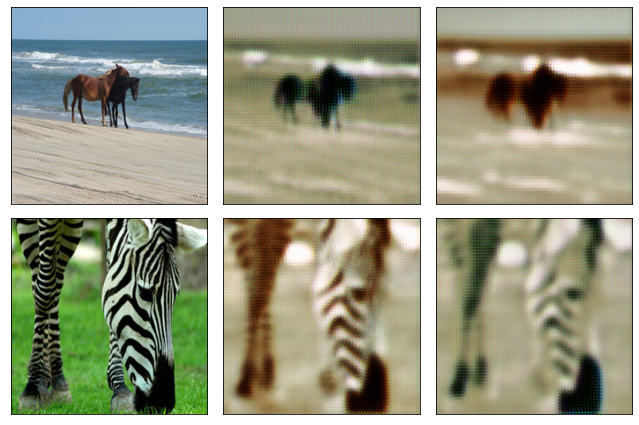

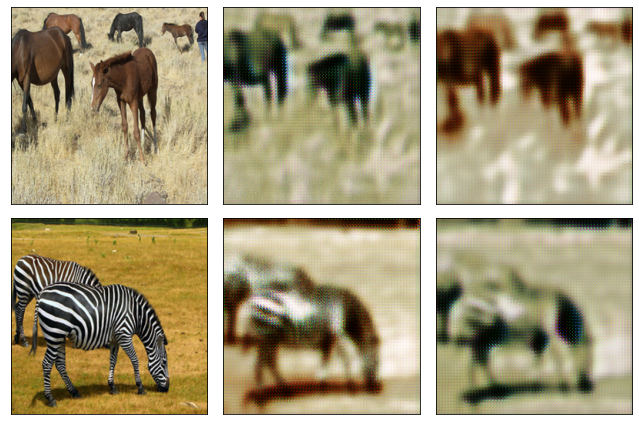

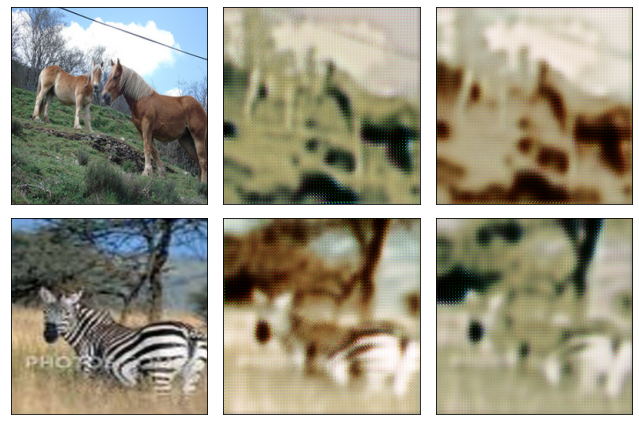

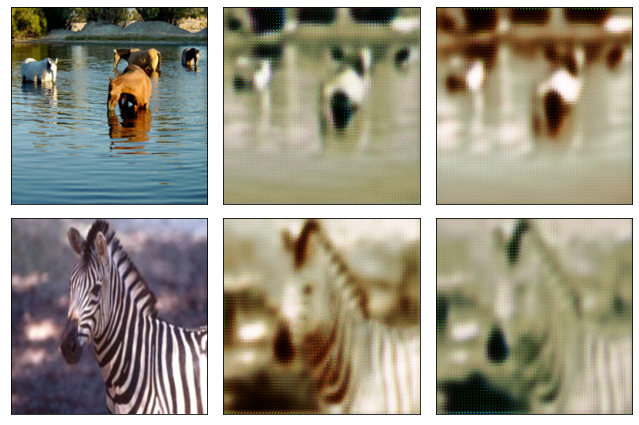

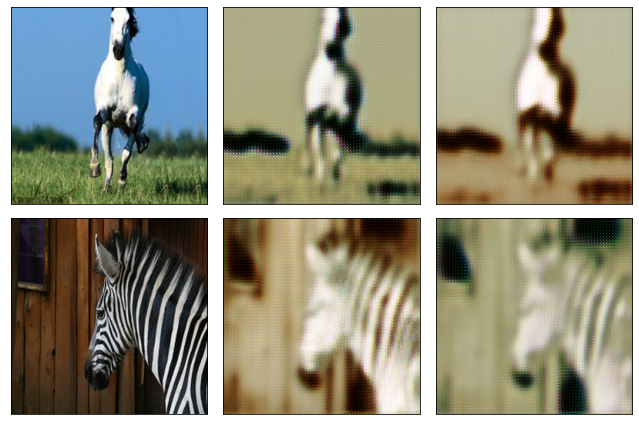

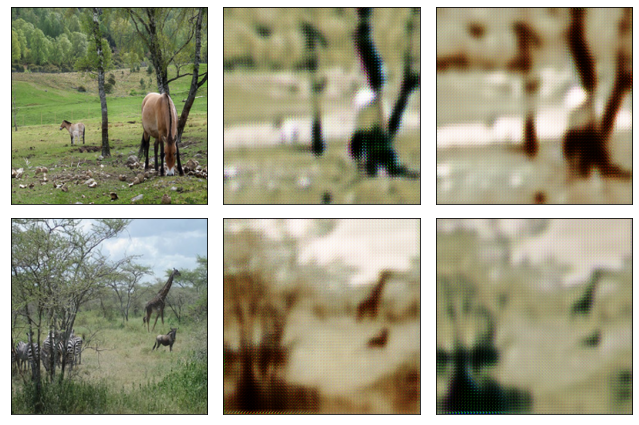

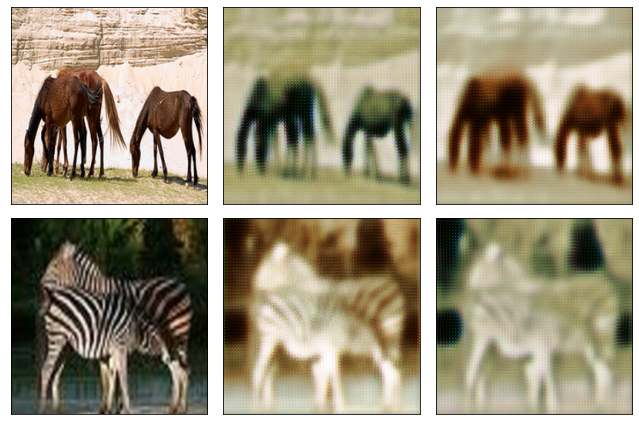

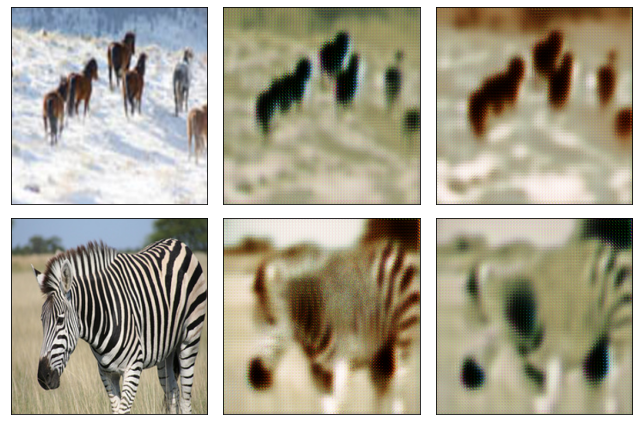

In [ ]:
for i in range(8): show_grid(test_ims[i])